# Multitasking Python

I/O bound processes are a typical example of advantages of concurrent/parallel processing over sequential execution.
Networking is a very common I/O bound task and is well suited for explaining different approaches to this problem.
Let's use link checker application as a real world example of I/O bound task.

## Link Checker

First, we need to have a list of links to check. It doesn't really matter what they are, so let me extract them from Wikipedia.

In [1]:
import requests
from bs4 import BeautifulSoup

I've been recently checking a [List of Nobel prize winners in Chemistry](https://en.wikipedia.org/wiki/List_of_Nobel_laureates_in_Chemistry), and there are a lot of links we can use for this project.

In [2]:
wiki_url = 'https://en.wikipedia.org/wiki/List_of_Nobel_laureates_in_Chemistry'
r = requests.get(wiki_url)
soup = BeautifulSoup(r.text, 'html.parser')

The main table on this page has a link for every Nobel laureate, country, etc. Let's use these links.

In [3]:
table = soup.table
links = []
for link in table.find_all('a'):
    links.append(link.get('href'))

In [4]:
links[:10]

['#endnote_1',
 '#endnote_2',
 '#endnote_3',
 '/wiki/File:Vant_Hoff.jpg',
 '/wiki/Jacobus_Henricus_van_%27t_Hoff',
 '/wiki/Netherlands',
 '/wiki/Chemical_dynamics',
 '/wiki/Osmotic_pressure',
 '#cite_note-19',
 '/wiki/File:Hermann_Emil_Fischer_c1895.jpg']

There is a mix of useful links I want to check like '/wiki/Chemical_dynamics' and references to pictures etc. which I don't want to use. We can extract useful links using regular expressions.

### How to regex?

For quick prototypes like this one, my usual process of writing regexes is the following:  
1. Get examples of text from which you want to extract information. Here's it's a `link[:10]` from above.
2. Go to [regex101](https://regex101.com/) and copy your examples.
3. Write your regex using Quick Reference from regex101. The site shows matches interactively which makes writing regex fast.
4. Use created pattern in Python with [re](https://docs.python.org/3/library/re.html)

![regex](images/regex.png)

In [5]:
import re
pattern = re.compile('\/wiki\/\w+$')

In [6]:
good_links = [link for link in links if pattern.match(link)]

In [7]:
base_url = 'https://en.wikipedia.org/'

In [8]:
full_links = [base_url + link for link in good_links]

In [9]:
full_links[:10]

['https://en.wikipedia.org//wiki/Netherlands',
 'https://en.wikipedia.org//wiki/Chemical_dynamics',
 'https://en.wikipedia.org//wiki/Osmotic_pressure',
 'https://en.wikipedia.org//wiki/Hermann_Emil_Fischer',
 'https://en.wikipedia.org//wiki/German_Empire',
 'https://en.wikipedia.org//wiki/Svante_Arrhenius',
 'https://en.wikipedia.org//wiki/Sweden',
 'https://en.wikipedia.org//wiki/Electrolyte',
 'https://en.wikipedia.org//wiki/William_Ramsay',
 'https://en.wikipedia.org//wiki/United_Kingdom']

Let's see how long it roughly takes to check all of these links. I want it to be long enough to see differnces between methods, but no need to wait forever. Around 1 minute should be enough.

In [10]:
import time

In [11]:
start = time.time()
for link in full_links:
    r = requests.get(link)
end = time.time()

In [12]:
print(f'Took {end - start:.2f} seconds')

Took 117.46 seconds


Ok, that's a bit too long, so let's get rid of 3/4 of the links.

In [13]:
import random
full_links = random.sample(full_links, round(0.25*len(full_links)))

In [14]:
start = time.time()
for link in full_links:
    r = requests.get(link)
end = time.time()

In [15]:
print(f'Took {end - start:.2f} seconds')

Took 29.21 seconds


Long enough to see the difference between various methods.

Let's break 10% of the links to simulate the task we want to perform.

In [16]:
def prep_test_links(links):
    to_break = random.sample(links, round(0.1*len(links)))
    broken = [link.replace('kipedia', 'asdf') for link in to_break]
    broken_count = len(broken)
    ok_count = len(links)
    test_links = links + broken
    random.shuffle(test_links)
    return test_links, broken_count, ok_count

## Sequential check

We can access links one-by-one and check how long it takes.

In [17]:
from requests.exceptions import ConnectionError

def is_working_link(link):
    try:
        r = requests.get(link)
    except ConnectionError:
        return False
    else:
        return True

In [18]:
def seq_check_links(links):
    ok_count = 0
    broken_count = 0
    for link in links:
        if is_working_link(link):
            ok_count += 1
        else:
            broken_count += 1
            
    return broken_count, ok_count

In [19]:
def seq_test():
    test_links, test_broken, test_ok = prep_test_links(full_links)
    broken_count, ok_count = seq_check_links(test_links)
    assert test_broken == broken_count
    assert test_ok == ok_count

In [20]:
%time seq_test()

CPU times: user 5.57 s, sys: 430 ms, total: 6 s
Wall time: 29.5 s


We can also see that while running this function takes ~30s, CPU is used only for ~5s. All the rest is spent waiting for I/O, which suggests that we should see a significant speed up from using other methods.

## Multithreaded check

For multhithreaded check I just want to make the same requests from different threads. We could use `threading` module for that, but instead I'm going to use `concurrent.futures` module. It provides consistent interface for running both threads and processes which is going to make the comparison clearer.

In [21]:
from concurrent.futures import ThreadPoolExecutor

The usual way of writing multithreaded code is to create function that processes one item and map it over a sequence of items to process. For sequential check I could have writien `check_links` function without `is_working_link` function, but I'm using it to make it more similar to what's required for multhithreading. We could even write sequential check using `map` function.

In [22]:
def seq_check_links(links):
    ok_count = sum(map(is_working_link, links))
    broken_count = len(links) - ok_count
            
    return broken_count, ok_count

In [23]:
def seq_test():
    test_links, test_broken, test_ok = prep_test_links(full_links)
    broken_count, ok_count = seq_check_links(test_links)
    assert test_broken == broken_count
    assert test_ok == ok_count

In [24]:
%time seq_test()

CPU times: user 5.51 s, sys: 419 ms, total: 5.93 s
Wall time: 31.1 s


Again we see that sequential check with `map` takes ~30s, but this version will make comparison clearer so, let's keep it this way.

In [25]:
def thread_check_links(links):
    with ThreadPoolExecutor(max_workers=2) as executor:
        ok_count = sum(executor.map(is_working_link, links))
    broken_count = len(links) - ok_count
            
    return broken_count, ok_count

In [26]:
def thread_test():
    test_links, test_broken, test_ok = prep_test_links(full_links)
    broken_count, ok_count = thread_check_links(test_links)
    assert test_broken == broken_count
    assert test_ok == ok_count

In [27]:
%time thread_test()

CPU times: user 5.13 s, sys: 414 ms, total: 5.55 s
Wall time: 14.8 s


Using 2 threads made checking links roughly twice as fast!  
But why stop there? Or in general how to know how many threads we should use?  
As with many other things in programming it's better to not make assumptions, but just test it.

In [28]:
def thread_check_links(num_threads, links):
    with ThreadPoolExecutor(max_workers=num_threads) as executor:
        ok_count = sum(executor.map(is_working_link, links))
    broken_count = len(links) - ok_count

    return broken_count, ok_count

In [29]:
def thread_test_performance():
    
    test_links, test_broken, test_ok = prep_test_links(full_links)
    
    num_threads = []
    times = []
    for n in (2**n for n in range(1, 7)):
        start = time.time()
        broken_count, ok_count = thread_check_links(n, test_links)
        assert test_broken == broken_count
        assert test_ok == ok_count
        end = time.time()
        
        num_threads.append(n)
        times.append(end-start)
    return num_threads, times

In [30]:
num_threads, times = thread_test_performance()

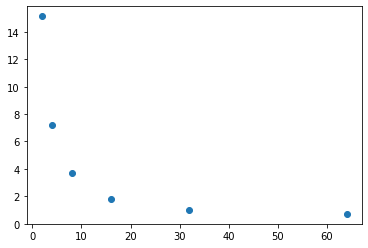

In [31]:
import matplotlib.pyplot as plt
plt.scatter(num_threads, times)
plt.show()

Each new thread takes some memory, so it doesn't make sense to create more of them for marginal speedup. 
For the final test let's use 16 threads.

In [32]:
def thread_check_links(links):
    with ThreadPoolExecutor(max_workers=16) as executor:
        ok_count = sum(executor.map(is_working_link, links))
    broken_count = len(links) - ok_count
            
    return broken_count, ok_count

In [33]:
%time thread_test()

CPU times: user 1.76 s, sys: 190 ms, total: 1.95 s
Wall time: 1.73 s


## Multiprocessing check

`concurrent.futures` library allows use to switch single line of code to move from multithreading to multiprocessing

In [34]:
from concurrent.futures import ProcessPoolExecutor

In [35]:
def multiprocess_check_links(links):
    with ProcessPoolExecutor(max_workers=2) as executor:
        ok_count = sum(executor.map(is_working_link, links))
    broken_count = len(links) - ok_count
            
    return broken_count, ok_count

In [36]:
def multiprocess_test():
    test_links, test_broken, test_ok = prep_test_links(full_links)
    broken_count, ok_count = multiprocess_check_links(test_links)
    assert test_broken == broken_count
    assert test_ok == ok_count

In [37]:
%time multiprocess_test()

Process SpawnProcess-1:
Traceback (most recent call last):
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.8/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.8/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.8/lib/python3.8/concurrent/futures/process.py", line 233, in _process_worker
    call_item = call_queue.get(block=True)
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.8/lib/python3.8/multiprocessing/queues.py", line 116, in get
    return _ForkingPickler.loads(res)
AttributeError: Can't get attribute 'is_working_link' on <module '__main__' (built-in)>
Process SpawnProcess-2:
Traceback (most recent call last):
  File "/Librar

BrokenProcessPool: A process in the process pool was terminated abruptly while the future was running or pending.

Something is not working here, but [SO](https://stackoverflow.com/questions/62488423/brokenprocesspool-while-running-code-in-jupyter-notebook)  comes with some help. And [here](https://github.com/ipython/ipython/issues/10894) we can find more specific explanation of the issue. I'll just move multiprocessing code to a separate file as suggested and import it from there. 

In [38]:
from multiprocessing_check import multiprocess_check_links

In [39]:
def multiprocess_test():
    test_links, test_broken, test_ok = prep_test_links(full_links)
    broken_count, ok_count = multiprocess_check_links(n=2, links=test_links)
    assert test_broken == broken_count
    assert test_ok == ok_count

In [40]:
%time multiprocess_test()

CPU times: user 84.9 ms, sys: 27.1 ms, total: 112 ms
Wall time: 14.7 s


Again, using 2 processes results in 2 times faster execution in comaprison to sequential check. Let's check what is the optimal number of process to run.

In [41]:
def multiprocess_test_performance():
    
    test_links, test_broken, test_ok = prep_test_links(full_links)
    
    num = []
    times = []
    for n in (2**n for n in range(1, 7)):
        start = time.time()
        broken_count, ok_count = multiprocess_check_links(n, test_links)
        assert test_broken == broken_count
        assert test_ok == ok_count
        end = time.time()
        
        num.append(n)
        times.append(end-start)
    return num, times

In [42]:
num, times = multiprocess_test_performance()

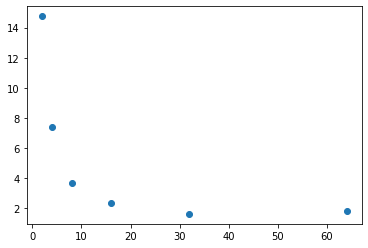

In [43]:
import matplotlib.pyplot as plt
plt.scatter(num, times)
plt.show()

In contrast to using multiple threads, with multiple process we can clearly see that the overhead for creating > 30 processes increases total time of execution.

Final test for multiprocessing

In [44]:
def multiprocess_test():
    test_links, test_broken, test_ok = prep_test_links(full_links)
    broken_count, ok_count = multiprocess_check_links(n=16, links=test_links)
    assert test_broken == broken_count
    assert test_ok == ok_count

In [45]:
%time multiprocess_test()

CPU times: user 47.5 ms, sys: 152 ms, total: 199 ms
Wall time: 2.12 s


This result is surprisingly similar to the execution time when we used multithreading.

As we know from "The Zen of Python" (`import this`) - "There should be one-- and preferably only one --obvious way to do it."  
How do we choose between multithreading vs multiprocessing given that they have very similar performance for our task?
The second most common concern for programs is the memory consumption and we can use it to get more insight about preferable choice.

In [46]:
%load_ext memory_profiler

In [47]:
%memit thread_test()

peak memory: 206.97 MiB, increment: 1.00 MiB


In [48]:
%memit multiprocess_test()

peak memory: 206.50 MiB, increment: 0.03 MiB


Wow there is surprinsingly little difference between multithreading and multiprocessing for our task. I'm not sure why it is like that, but I think that it might be related to running these profiling experiments in Jupyter Notebook. Let's move final time/memory profiling to plain files.

## AsyncIO

Threads and processes seem to be more common and better understood, so let's start with the question - what is async IO?

Async IO is a style of concurrent programming. It's single-threaded and single-process with concurrency happening at the function level. Async IO functions are called coroutines and are a specialized version of a Python generator functions. A coroutine is a function that can suspend its execution before reaching return, and it can indirectly pass control to another coroutine for some time.

### AsyncIO Hello World

In [49]:
import asyncio

async def hello_world():
    print('Hello')
    await asyncio.sleep(1)
    print('World')
    
async def main():
    await asyncio.gather(*(hello_world() for _ in range(10))) # see later comment

In [50]:
s = time.time()
await main()
e = time.time()

Hello
Hello
Hello
Hello
Hello
Hello
Hello
Hello
Hello
Hello
World
World
World
World
World
World
World
World
World
World


In [51]:
print(f'Took {e - s:.2f} seconds')

Took 1.01 seconds


Execution takes 1 second, because on the one hand sleeping for 1 second is performed, but coroutine doesn't block execution of another coroutine, so effectively they all are waiting 1 second at the same time.

The `main` function with its
```python
await asyncio.gather(*(hello_world() for _ in range(10)))
```
might be a bit too ambitious to call it "Hello World" example, so let's unpack what's going on there.

1. `await` keyword is used to actually run coroutines. Once we define async function, we can use `await` to run it.

In [52]:
async def hey():
    return 'hey'

In [53]:
hey()

<coroutine object hey at 0x10a130bc0>

Calling async function normally does not return any result.

In [54]:
await hey()

'hey'

`await` is a keyword we can use for running async function.

2. `asyncio.gather` - is used to run sequence of coroutines concurrently.  
We usually multiplpe define async functions and then run them concurrently and `gather` is exactly a mechanism used for requesting concurrent execution of async functions. For example:

In [55]:
await asyncio.gather(hey(), hey(), hey())

['hey', 'hey', 'hey']

3. `*(hello_world() for _ in range(10))` - I want to run 10 coroutines `hello_world`, but I obviously don't want to type it 10 times. Instead, I'm using generator expression `(hello_world() for _ in range(10)` that yields 10 coroutines. However, `gather` function accepts each coroutine as a separate argument, so I'm unpacking my generator with `*`.

In [56]:
(hello_world for _ in range(10))

<generator object <genexpr> at 0x1348ec120>

In [57]:
print(*(hello_world for _ in range(10)))

<function hello_world at 0x134971790> <function hello_world at 0x134971790> <function hello_world at 0x134971790> <function hello_world at 0x134971790> <function hello_world at 0x134971790> <function hello_world at 0x134971790> <function hello_world at 0x134971790> <function hello_world at 0x134971790> <function hello_world at 0x134971790> <function hello_world at 0x134971790>


### AsyncIO requests

`requests` library I was using for all the previous examples makes sequetial network calls that we were able to speed up by spreading them over multiple threads or process. This is not going to work with Async IO model, and to make network calls in coroutines we need to use `aiohttp` module.

In [58]:
import aiohttp
from aiohttp import client_exceptions

Let's start with async `check_link`

In [59]:
async def check_link(session, link):
    try:
        async with session.get(link) as response:
            return response.status == 200
    except client_exceptions.ClientConnectionError as e:
        return False
    else:
        return True

In [60]:
await check_link(aiohttp.ClientSession(), 'https://en.wikipedia.org//wiki/Japan')

Unclosed client session
client_session: <aiohttp.client.ClientSession object at 0x134bc0610>


True

Seems to be working fine for one exmaple, so let's prepare full test

In [61]:
async def async_check_links(links):
    async with aiohttp.ClientSession() as session:
        tasks = []
        for link in links:
            tasks.append(check_link(session, link))
            
        results = await asyncio.gather(*tasks)

    ok_count = sum(result for result in results)    
    broken_count = len(links) - ok_count
    
    return broken_count, ok_count

In [62]:
async def async_test():
    test_links, test_broken, test_ok = prep_test_links(full_links)
    broken_count, ok_count = await async_check_links(test_links)
    
    assert test_broken == broken_count
    assert test_ok == ok_count

In [63]:
%time await async_test()

SyntaxError: 'await' outside function (<timed eval>, line 1)

Jupyter doesn't seem to work well with async code. Let's run one simple test here and move further profiling to files.

In [64]:
s = time.time()
await async_test()
e = time.time()
print(f'Took {e - s:.2f} seconds')

Took 0.80 seconds


Even though AsyncIO requires special syntax and is not as easy to write as the other methods, it provides the fastest execution for network requests. Let's move on to a more detailed profiling in files.